### Starbucks Capstone Challenge
# Linear Classifier

This notebook aims to train a feed-forward neural network to classify offer sending as appropriate or not. Being a traditional classification approach, this model will be the benchmark model to compare other classification methods.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from models import LinearNN

In [2]:
!unzip -o dataloaders.zip
train_dataloader, valid_dataloader, test_dataloader = \
    torch.load('dataloaders.pt')

Archive:  dataloaders.zip
  inflating: dataloaders.pt          


In [3]:
def validate(model, dataloader=valid_dataloader):
    with torch.no_grad():
        model.eval()
        POS, NEG = 0, 0
        TP, TN, FP, FN = 0, 0, 0, 0
        valid_loss = 0
        for features, targets in dataloader:
            targets = targets.view(-1)
            positive = targets == 1
            negative = ~positive

            prediction = model(features)
            targets = targets.view(-1,1).to(dtype=torch.float)
            valid_loss += criterion(prediction, targets)

            prediction = torch.sigmoid(prediction)
            prediction = prediction.round()

            ## Compare prediction with target POSITIVE
            POS += positive.sum()
            # Target TRUE, Prediction TRUE --> True Positive
            TP += targets[positive].eq(prediction[positive]).sum()

            ## Compare prediction with target NEGATIVE
            NEG += negative.sum()
            # Target FALSE, Prediction FALSE --> True Negative
            TN += targets[negative].eq(prediction[negative]).sum()

        FN += POS - TP # Target TRUE, Prediction FALSE --> False Negative
        FP += NEG - TN # Target FALSE, Prediction TRUE --> False Positive

        # normalize the loss
        valid_loss /= len(dataloader)
        
        print(f'\n\tValidation ... loss: {valid_loss:7.4f}')
        print(f'\t\tTP: {TP:4d}\tFP: {FP:4d}\tOP: {TP+FP:4d}')
        print(f'\t\tFN: {FN:4d}\tTN: {TN:4d}\tON: {TN+FN:4d}')
        print(f'\t\tCP: {POS:4d}\tCN: {NEG:4d}')
        print('\tAccuracy: {:5.2f}%\tPrecision: {:5.2f}\tRecall: {:5.2f}\n'
              .format((TP+TN)/float(POS+NEG)*100,
                      TP/float(TP+FP), TP/float(TP+FN)))

        model.train()

In [4]:
linear_classifier = LinearNN(input_size=16, output_size=1,
                             hidden_layers=[128,64,32])
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(linear_classifier.parameters(), lr=0.00009)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.2, patience=100, verbose=True)


In [5]:
def train(model, dataloader=train_dataloader, epochs=5000):
    train_loss = []
    ## Perform N epochs of training
    for epoch in range(1, epochs+1):
        epoch_loss = 0
        for batch, (features, targets) in enumerate(dataloader):
            ## Train the network
            optimizer.zero_grad()
            prediction = model(features)
            targets = targets.view(-1,1).to(dtype=torch.float)
            loss = criterion(prediction, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Normalize the loss
        epoch_loss /= len(dataloader)
        train_loss.append(epoch_loss)
        lr_scheduler.step(train_loss[-1])

        print('Epoch {:4d}\ttraining loss: {:7.4f}' \
              .format(epoch, train_loss[-1]))
        if epoch % 10 == 0:
            validate(model)

    print('\n')
    return train_loss

Epoch    1	training loss:  0.6938
Epoch    2	training loss:  0.6927
Epoch    3	training loss:  0.6905
Epoch    4	training loss:  0.6897
Epoch    5	training loss:  0.6897
Epoch    6	training loss:  0.6894
Epoch    7	training loss:  0.6893
Epoch    8	training loss:  0.6894
Epoch    9	training loss:  0.6893
Epoch   10	training loss:  0.6892

	Validation ... loss:  0.6885
		TP: 1489	FP: 1031	OP: 2520
		FN: 2731	TN: 4295	ON: 7026
		CP: 4220	CN: 5326
	Accuracy: 60.59%	Precision:  0.59	Recall:  0.35

Epoch   11	training loss:  0.6889
Epoch   12	training loss:  0.6891
Epoch   13	training loss:  0.6891
Epoch   14	training loss:  0.6889
Epoch   15	training loss:  0.6890
Epoch   16	training loss:  0.6890
Epoch   17	training loss:  0.6887
Epoch   18	training loss:  0.6887
Epoch   19	training loss:  0.6889
Epoch   20	training loss:  0.6889

	Validation ... loss:  0.6881
		TP: 1630	FP: 1124	OP: 2754
		FN: 2590	TN: 4202	ON: 6792
		CP: 4220	CN: 5326
	Accuracy: 61.09%	Precision:  0.59	Recall:  0.39

Ep

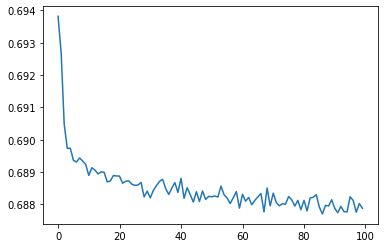

In [6]:
train_loss = train(linear_classifier, epochs=100)
plt.plot(train_loss)
plt.show()

In [7]:
validate(linear_classifier, test_dataloader)


	Validation ... loss:  0.6873
		TP: 1667	FP: 1134	OP: 2801
		FN: 2557	TN: 4188	ON: 6745
		CP: 4224	CN: 5322
	Accuracy: 61.33%	Precision:  0.60	Recall:  0.39

